In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared,
    DotProduct,
    Exponentiation,
    RationalQuadratic
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, silhouette_score,silhouette_samples,adjusted_rand_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier




In [258]:
#function for segmenting train and test sets into time segments
def extract_segments(df):
    segments = []
    window=329
    for start in range(0, len(df) - window + 1, window):
        win = df.iloc[start:start+window]
        stats = win.agg(['mean', 'std']).values.flatten()
        segments.append((stats))
    return np.array(segments)

In [260]:
#loading data and segmenting
train_normal_filepath='DATA/Train01_normal.csv'
test_normal_filepath='DATA/Test_segments_Normal.csv'

train_semiblocked_filepath='DATA/Train02_semi-blocked.csv'
test_semiblocked_filepath='DATA/Test_segments_SemiBlocked.csv'

train_blocked_filepath='DATA/Train03_blocked.csv'
test_blocked_filepath='DATA/Test_segments_Blocked.csv'

train_runout_filepath='DATA/Train04_run-out-of-material.csv'
test_runout_filepath='DATA/Test_segments_RunOut.csv'


test_normal=pd.read_csv(test_normal_filepath)
train_normal=pd.read_csv(train_normal_filepath)
test_semiblocked=pd.read_csv(test_semiblocked_filepath)
train_semiblocked=pd.read_csv(train_semiblocked_filepath)
test_blocked=pd.read_csv(test_blocked_filepath)
train_blocked=pd.read_csv(train_blocked_filepath)
test_runout=pd.read_csv(test_runout_filepath)
train_runout=pd.read_csv(train_runout_filepath)


train_normal = train_normal.drop(columns=['HH:MM:SS.mmmuuun    '])
train_semiblocked = train_semiblocked.drop(columns=['HH:MM:SS.mmmuuun    '])
train_blocked = train_blocked.drop(columns=['HH:MM:SS.mmmuuun    '])
train_runout = train_runout.drop(columns=['HH:MM:SS.mmmuuun    '])
test_normal = test_normal.drop(columns=['segment'])
test_semiblocked = test_semiblocked.drop(columns=['segment'])
test_blocked = test_blocked.drop(columns=['segment'])
test_runout = test_runout.drop(columns=['segment'])

train_normal = train_normal.drop(columns=['THR '])
train_semiblocked = train_semiblocked.drop(columns=['THR '])
train_blocked = train_blocked.drop(columns=['THR '])
train_runout = train_runout.drop(columns=['THR '])
test_normal = test_normal.drop(columns=['THR'])
test_semiblocked = test_semiblocked.drop(columns=['THR'])
test_blocked = test_blocked.drop(columns=['THR'])
test_runout = test_runout.drop(columns=['THR'])

test_reduced=np.vstack([extract_segments(test_normal),extract_segments(test_semiblocked),extract_segments(test_blocked),extract_segments(test_runout)])
train_reduced=np.vstack([extract_segments(train_normal),extract_segments(train_semiblocked),extract_segments(train_blocked),extract_segments(train_runout)])
print(np.shape(extract_segments(test_normal)))
print(np.shape(extract_segments(test_semiblocked)))
print(np.shape(extract_segments(test_blocked)))
print(np.shape(extract_segments(test_runout)))
print(np.shape(test_reduced))

print(np.shape(extract_segments(train_normal)))
print(np.shape(extract_segments(train_semiblocked)))
print(np.shape(extract_segments(train_blocked)))
print(np.shape(extract_segments(train_runout)))
print(np.shape(train_reduced))

train_normal = train_normal.to_numpy()
train_semiblocked = train_semiblocked.to_numpy()
train_blocked = train_blocked.to_numpy()
train_runout = train_runout.to_numpy()
 
training_data = np.append(train_normal, train_semiblocked, axis=0)
training_data = np.append(training_data, train_blocked, axis=0)
training_data = np.append(training_data, train_runout, axis=0)


test_normal = test_normal.to_numpy()
test_semiblocked = test_semiblocked.to_numpy()
test_blocked = test_blocked.to_numpy()
test_runout = test_runout.to_numpy()

test_data = np.append(test_normal, test_semiblocked, axis=0)
test_data = np.append(test_data, test_blocked, axis=0)
test_data = np.append(test_data, test_runout, axis=0)


(6, 38)
(6, 38)
(6, 38)
(6, 38)
(24, 38)
(32, 38)
(37, 38)
(33, 38)
(44, 38)
(146, 38)


In [262]:
#known classes for training and test
zeros = np.zeros(6, dtype=int)
ones = np.ones(6, dtype=int)
twos = np.full(6, 2, dtype=int)
threes = np.full(6, 3, dtype=int)
y_test = np.concatenate([zeros, ones, twos, threes])

zeros = np.zeros(32, dtype=int)
ones = np.ones(37, dtype=int)
twos = np.full(33, 2, dtype=int)
threes = np.full(44, 3, dtype=int)
y_train = np.concatenate([zeros, ones, twos, threes])

In [202]:
#grid search for full time segment data
param_grid = {
    'n_estimators': [1, 2, 3,4,5,6,7,8,9,10,25,50,100,200,1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 4,5,10,15,20,50,100]
}

rf = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_reduced, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("\nBest Parameters Found:", grid_search.best_params_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Best Parameters Found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1}


              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.86      1.00      0.92         6

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

Class 0 accuracy: 83.33%
Class 1 accuracy: 100.00%
Class 2 accuracy: 100.00%
Class 3 accuracy: 100.00%
Total accuracy: 95.83%
[[5 0 0 1]
 [0 6 0 0]
 [0 0 6 0]
 [0 0 0 6]]


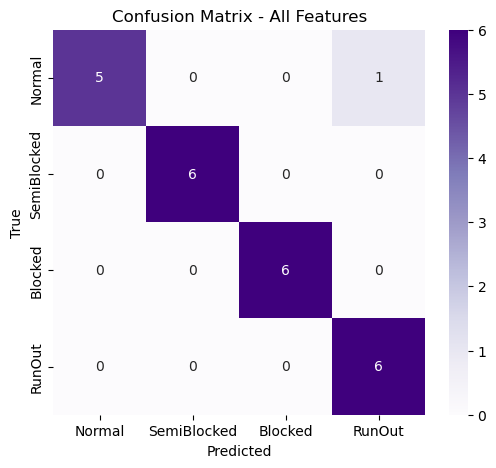

In [264]:
#model and predictions with tuned hyperparameters for full time segment data
model = RandomForestClassifier(n_estimators=1,max_depth=None,min_samples_split=2, random_state=1)
model.fit(train_reduced, y_train)
y_pred = model.predict(test_reduced)

print(classification_report(y_test, y_pred))

acc_arr=[]
for label in range(4):
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_pred[idx])
    acc_arr.append(acc)
    print(f"Class {label} accuracy: {acc * 100:.2f}%")

overall_accuracy = np.mean(acc_arr)
print(f"Total accuracy: {overall_accuracy * 100:.2f}%")


conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Normal", "SemiBlocked", "Blocked", "RunOut"],
            yticklabels=["Normal", "SemiBlocked", "Blocked", "RunOut"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - All Features")
plt.show()

In [204]:
#print(train_reduced[:,[1,6,12,20,25,31]])

In [190]:
#grid serach for time segment data with just count, RMS and ABS-Energy features like the paper
param_grid = {
    'n_estimators': [1, 2, 3,4,5,6,7,8,9,10,25,50,100,200,1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 4,5,10,15,20,50,100]
}

rf = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_reduced[:,[1,6,12,20,25,31]], y_train)

# Best model
best_rf = grid_search.best_estimator_
print("\nBest Parameters Found:", grid_search.best_params_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Best Parameters Found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 4}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         6
           3       1.00      0.83      0.91         6

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24

Class 0 accuracy: 100.00%
Class 1 accuracy: 100.00%
Class 2 accuracy: 100.00%
Class 3 accuracy: 83.33%
Total accuracy: 95.83%
[[6 0 0 0]
 [0 6 0 0]
 [0 0 6 0]
 [0 1 0 5]]


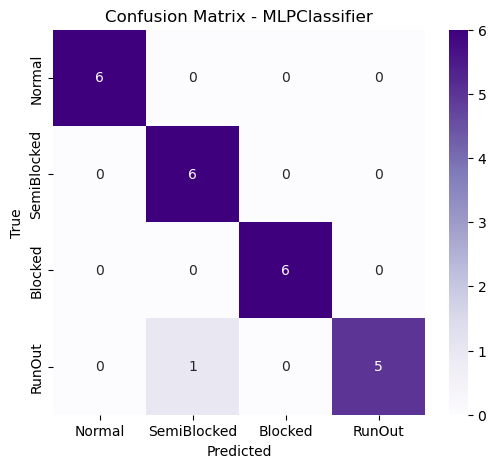

In [266]:
#model and predictions with tuned hyperparameters for time segment data with just count, RMS and ABS-Energy features like the paper
model = RandomForestClassifier(n_estimators=4,max_depth=None,min_samples_split=2, random_state=1)
model.fit(train_reduced[:,[1,6,12,20,25,31]], y_train)
y_pred = model.predict(test_reduced[:,[1,6,12,20,25,31]])

print(classification_report(y_test, y_pred))

acc_arr=[]
for label in range(4):
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_pred[idx])
    acc_arr.append(acc)
    print(f"Class {label} accuracy: {acc * 100:.2f}%")

overall_accuracy = np.mean(acc_arr)
print(f"Total accuracy: {overall_accuracy * 100:.2f}%")


conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Normal", "SemiBlocked", "Blocked", "RunOut"],
            yticklabels=["Normal", "SemiBlocked", "Blocked", "RunOut"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLPClassifier")
plt.show()

In [192]:
#grid search from time segment data with important features deemed by simple data processing (data_processing.py)
param_grid = {
    'n_estimators': [1, 2, 3,4,5,6,7,8,9,10,25,50,100,200,1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 4,5,10,15,20,50,100]
}

rf = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_reduced[:,[1,4,6,7,13,14,15,16,20,23,25,26,32,33,34,35]], y_train)

# Best model
best_rf = grid_search.best_estimator_
print("\nBest Parameters Found:", grid_search.best_params_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Best Parameters Found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 25}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Class 0 accuracy: 100.00%
Class 1 accuracy: 100.00%
Class 2 accuracy: 100.00%
Class 3 accuracy: 100.00%
Total accuracy: 100.00%
[[6 0 0 0]
 [0 6 0 0]
 [0 0 6 0]
 [0 0 0 6]]


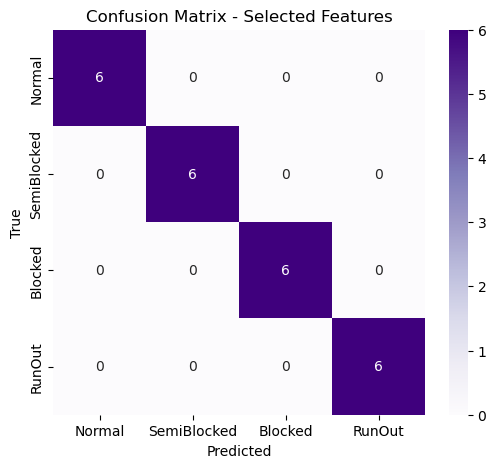

In [270]:
#model and predictions with tuned hyperparameters for time segment data with "important" features ((data_processing.py))
model = RandomForestClassifier(n_estimators=25,max_depth=None,min_samples_split=2, random_state=1)
model.fit(train_reduced[:,[1,4,6,7,13,14,15,16,20,23,25,26,32,33,34,35]], y_train)
y_pred = model.predict(test_reduced[:,[1,4,6,7,13,14,15,16,20,23,25,26,32,33,34,35]])

print(classification_report(y_test, y_pred))

acc_arr=[]
for label in range(4):
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_pred[idx])
    acc_arr.append(acc)
    print(f"Class {label} accuracy: {acc * 100:.2f}%")

overall_accuracy = np.mean(acc_arr)
print(f"Total accuracy: {overall_accuracy * 100:.2f}%")


conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Normal", "SemiBlocked", "Blocked", "RunOut"],
            yticklabels=["Normal", "SemiBlocked", "Blocked", "RunOut"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Selected Features")
plt.show()